## CHARACTERISTIC RADIUS R+

In [1]:
import sys,os
sys.path.append('../')

# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from datetime import datetime

# Custom
import functions as f
# import plotUtils as pu

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PARAMS = {'save_data':        False,
          'data_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
          'save_dir':         '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_STEADY_STATE_CRIT/03_CHARAC_RADIUS/',          
          'save_figs':        False,
}

### OPEN DATA
all_data = glob.glob(PARAMS['data_dir'] + "*.nc")
print("Total number of files:", len(all_data))

Total number of files: 335


In [3]:
dsg = xr.open_dataset('/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc')

### Add intensification parameters
dsg2 = xr.open_dataset('/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_17102022_with_extra_params.nc')
dsg['Vmax_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_smth_IBT']),
    coords={'time': dsg.time}
)
dsg['Vmax_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_smth_IBT']),
    coords={'time': dsg.time}
)

### Kinetic energy
K1_SAR = dsg['Vmax_1D'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R17_1D'] * 1000) ** 2)
K2_SAR = dsg['R17_1D'] * 1000 * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_1D'] ** 2)
K1_IBT = dsg['Vmax_IBT'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R34_IBT']) ** 2) 
K2_IBT = dsg['R34_IBT'] * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_IBT'] ** 2)

dsg['dKdt_SAR'] = K1_SAR + K2_SAR
dsg['dKdt_IBT'] = K1_IBT + K2_IBT

In [4]:
### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
# dsg = dsg.where(dsg.lon_center < -50, drop=True) # Keep only USA best-track agencies
# dsg = dsg.where(dsg.distance_to_coast > 200000, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

print('SAR Mean Rmax = {:.0f} km'.format(dsg.Rmax_1D.mean()))
print('SAR Mean R64  = {:.0f} km'.format(dsg.R33_1D.mean()))

Nb of storms: 195
SAR Mean Rmax = 34 km
SAR Mean R64  = 57 km


### Characteristic radius R+

In [5]:
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    # B     = (Vmax ** 2) * rho * np.e / (pn - pc)
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(np.float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

rs = np.linspace(0, 500000, 50001) # define dr accordingly
def vorticity(r, v):
    '''Relative vorticity'''
    dr = 10 # meters
    return (1 / r) * np.gradient(r * v, dr)

In [6]:
rs  = np.linspace(0, 500000, 50001)
n   = 5
DSs = dsg.mean(dim='theta', skipna=True)

# Initialize
DSs['R_plus'] = DSs['Vmax_1D'].copy(deep=True) * np.nan
DSs['V_plus'] = DSs['Vmax_1D'].copy(deep=True) * np.nan

for t in tqdm(np.arange(len(DSs.time))):
    ds       = DSs.isel(time=t)
    Vh       = holland_profile(rs, float(abs(ds.lat_center)), float(ds.pn_hol), float(ds.pc_hol), float(ds.Vmin_hol), float(ds.Rmax_hol), float(ds.Vmax_hol))
    rm       = float(ds.Rmax_hol)
    out      = rs > rm                             # To find outer-core
    r        = rs[out]
    vrt      = vorticity(rs, Vh)[out]              # Relative vorticity
    vrt_plan = float(abs(coriolis(ds.lat_center))) # Planetary vorticity
    
    try: 
        R_plus =  r[abs(vrt - n * vrt_plan) < 1e-7][0] 
        V_plus = ds.sel(rad=slice(R_plus - 500, None)).wind_speed[0]
    except IndexError:
        R_plus = V_plus = np.nan
    
    DSs['R_plus'][t] = R_plus
    DSs['V_plus'][t] = V_plus

100%|████████████████████████████████████████| 195/195 [00:01<00:00, 110.58it/s]


In [7]:
### TODO: Why so may NaNs?

In [8]:
DSs.R_plus

<xarray.DataArray 'R_plus' (time: 195)>
array([72450., 50230., 47620., 72620., 49090., 49370., 62120., 43980.,
       52360., 72910., 42810., 45230., 55450., 43200., 67560., 68140.,
       72270., 81510., 61540., 38310., 64010.,    nan, 53360., 87480.,
       72380., 51670., 37480., 38770., 49240., 43840., 44760., 48150.,
       57080., 81030., 66190., 76090., 84410., 65260., 53530., 64990.,
       47080., 84540., 67690., 45110., 79450., 90030., 46350., 78010.,
       56940., 48130., 75210., 65200., 51890., 63050., 48200., 49900.,
       72030., 71800.,    nan, 31830., 71410., 56470., 52110., 84350.,
       91650., 55930., 88680., 34870., 61550., 21920., 71910., 40060.,
       63770., 73090., 40940., 61110., 36270., 50180., 77720., 69200.,
       78440., 56160.,    nan, 46700., 91750., 40730., 58300., 70210.,
       50210., 98780., 65360., 54080., 71640., 77540., 49580., 42540.,
       43820., 54900., 74460., 53730., 46210., 60400., 37620., 58400.,
       66520., 48920., 43190., 75830., 60560., 32340., 58490., 59170.,
       36900., 76730., 84930., 45830., 51000.,    nan, 47770.,    nan,
       61340., 54330., 50310., 78030.,    nan, 80780., 58930., 73630.,
       41630., 55040., 53980., 99410., 55230.,    nan, 53350.,    nan,
       72940., 86550., 87260., 55720., 47490., 52360., 60310., 51060.,
       69110., 41690., 57550., 62300., 73980., 48000., 71800., 72060.,
       52980., 32260., 57720., 85480.,    nan, 53990., 80320., 61010.,
       88610., 51060., 82550., 51040., 90090., 58020., 52780., 52740.,
       58330., 78160., 37330., 46180., 43640., 93870., 67800., 43680.,
       80870., 57980., 67090., 79370., 57350., 54880., 84390.,    nan,
       34220., 52350., 63400., 92410.,    nan, 79440., 48090., 57210.,
       75690., 45130., 56290.])
Coordinates:
  * time     (time) datetime64[ns] 2021-04-21T09:44:30 ... 2019-12-31T14:45:18

In [9]:
# ITERATE
listOfDatasets = []
rf             = np.linspace(0.05, 5, 100)

for t in tqdm(np.arange(len(DSs.time))):
    ds  = DSs.isel(time=t)
    rv2 = (ds.rad * (ds.wind_speed ** 2)) / (ds.R_plus * (ds.V_plus ** 2))
    
    if ~np.isnan(ds.R_plus):
        dsr = xr.Dataset(
            data_vars={
                'rv2': ('r_star', np.array(rv2)),
                'B':   float(ds.B_hol),
            },
            coords={'r_star': np.array(ds.rad / (ds.R_plus))}
        )
        listOfDatasets.append(dsr.interp(coords={'r_star': rf}))

print('Concatenating...')
dss = xr.concat(listOfDatasets, dim='i')
print('Concatenation ended.')

100%|████████████████████████████████████████| 195/195 [00:01<00:00, 128.09it/s]


Concatenating...
Concatenation ended.


100%|████████████████████████████████████████| 184/184 [00:00<00:00, 456.73it/s]


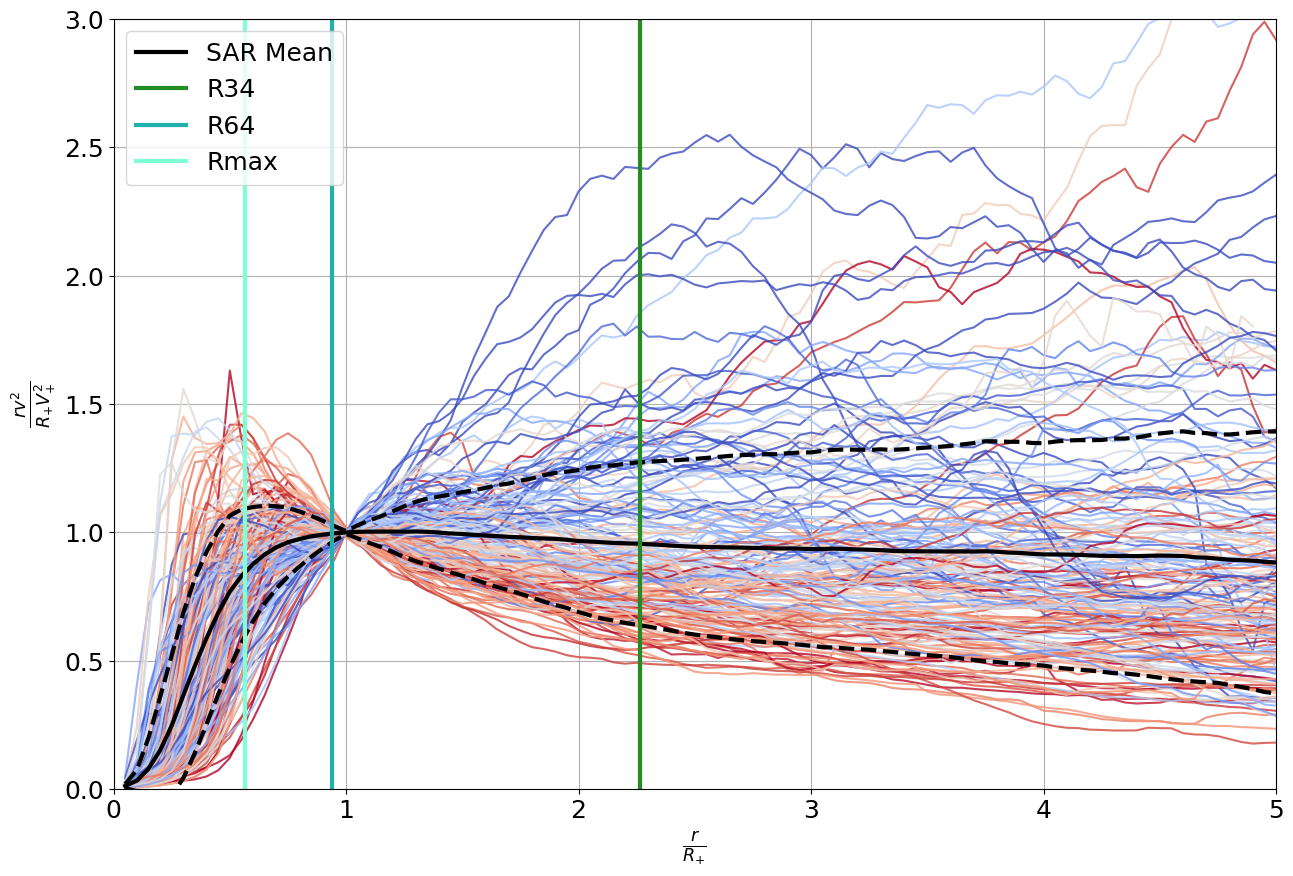

In [10]:
dss['B_color'] = (dss.B - 1.1) / (2.5 - 1.1)
cmap           = cm.get_cmap('coolwarm')

rv2m = dss.mean(dim='i').rv2
rv2s = dss.std(dim='i').rv2

for i in tqdm(np.arange(len(dss.i))):
    dss.isel(i=i).rv2.plot(color=cmap(dss.isel(i=i).B_color), alpha=0.8)

rv2m.plot(c='k', linewidth=3, label='SAR Mean')
plt.plot(dss.r_star, rv2m + rv2s, c='k', linestyle='dashed', linewidth=3)
plt.plot(dss.r_star, rv2m - rv2s, c='k', linestyle='dashed', linewidth=3)


# plt.axvline(1, c='k', linewidth=3, label='R+')
plt.axvline((DSs.R17_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True),  c='forestgreen', label='R34', linewidth=3)
plt.axvline((DSs.R33_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True),  c='lightseagreen', label='R64', linewidth=3)
plt.axvline((DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), c='aquamarine', label='Rmax', linewidth=3)
plt.grid();plt.legend()
plt.ylim(0, 3);plt.xlim(0, 5)
plt.ylabel(r'$\frac{rv^2}{R_{+} V_{+}^2}$')
plt.xlabel(r'$\frac{r}{R_{+}}$')
# plt.xlabel('r / R+')

if PARAMS['save_figs']:
    plt.savefig(PARAMS['save_dir'] + 'rv2_charac.pdf', bbox_inches='tight', format='pdf')

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  3.,  1.,  1.,  3.,  4.,  1.,  4.,
         4.,  8.,  6.,  9.,  5.,  9.,  8.,  9.,  7.,  8.,  8.,  4.,  6.,
         3.,  5.,  3.,  5.,  2.,  2., 12.,  4.,  4.,  2.,  5.,  5.,  3.,
         1.,  5.,  2.,  2.,  4.,  1.,  2.,  1.,  0.,  0.,  2.]),
 array([21920. , 23469.8, 25019.6, 26569.4, 28119.2, 29669. , 31218.8,
        32768.6, 34318.4, 35868.2, 37418. , 38967.8, 40517.6, 42067.4,
        43617.2, 45167. , 46716.8, 48266.6, 49816.4, 51366.2, 52916. ,
        54465.8, 56015.6, 57565.4, 59115.2, 60665. , 62214.8, 63764.6,
        65314.4, 66864.2, 68414. , 69963.8, 71513.6, 73063.4, 74613.2,
        76163. , 77712.8, 79262.6, 80812.4, 82362.2, 83912. , 85461.8,
        87011.6, 88561.4, 90111.2, 91661. , 93210.8, 94760.6, 96310.4,
        97860.2, 99410. ]),
 <BarContainer object of 50 artists>)

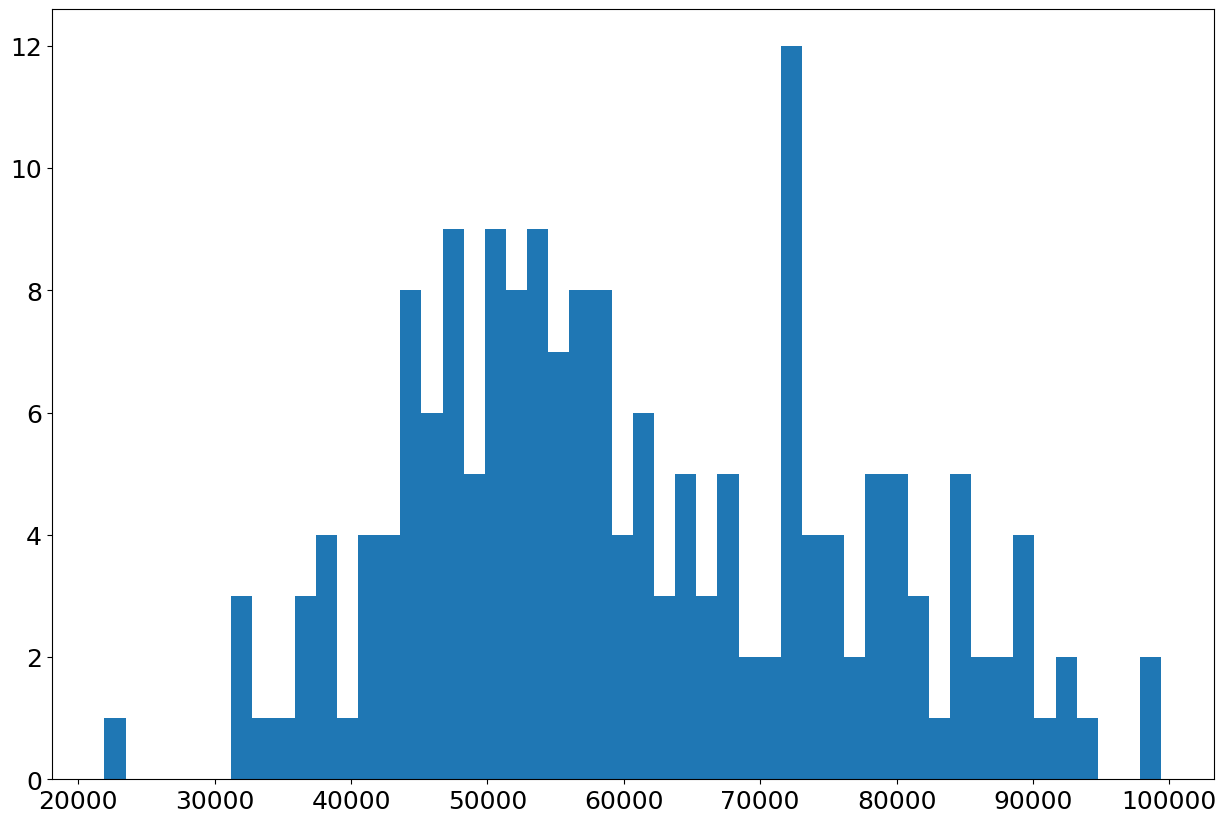

In [11]:
plt.hist(DSs.R_plus, bins=50)

In [12]:
# ITERATE
listOfDatasets = []
rf             = np.linspace(0.05, 5, 100)

for t in tqdm(np.arange(len(DSs.time))):
    ds  = DSs.isel(time=t)
    rv2 = (ds.rad * (ds.wind_speed ** 2)) / (ds.Rmax_1D * 1000 * (ds.Vmax_1D ** 2))
    
    if ~np.isnan(ds.Rmax_1D):
        dsr = xr.Dataset(
            data_vars={
                'rv2': ('r_star', np.array(rv2)),
                'B':   float(ds.B_hol),
            },
            coords={'r_star': np.array(ds.rad / (ds.Rmax_1D * 1000))}
        )
        listOfDatasets.append(dsr.interp(coords={'r_star': rf}))

print('Concatenating...')
dss2 = xr.concat(listOfDatasets, dim='i')
print('Concatenation ended.')

100%|████████████████████████████████████████| 195/195 [00:01<00:00, 129.78it/s]


Concatenating...
Concatenation ended.


100%|████████████████████████████████████████| 195/195 [00:00<00:00, 520.64it/s]


Text(0.5, 0, '$\\frac{r}{R_{+}}$')

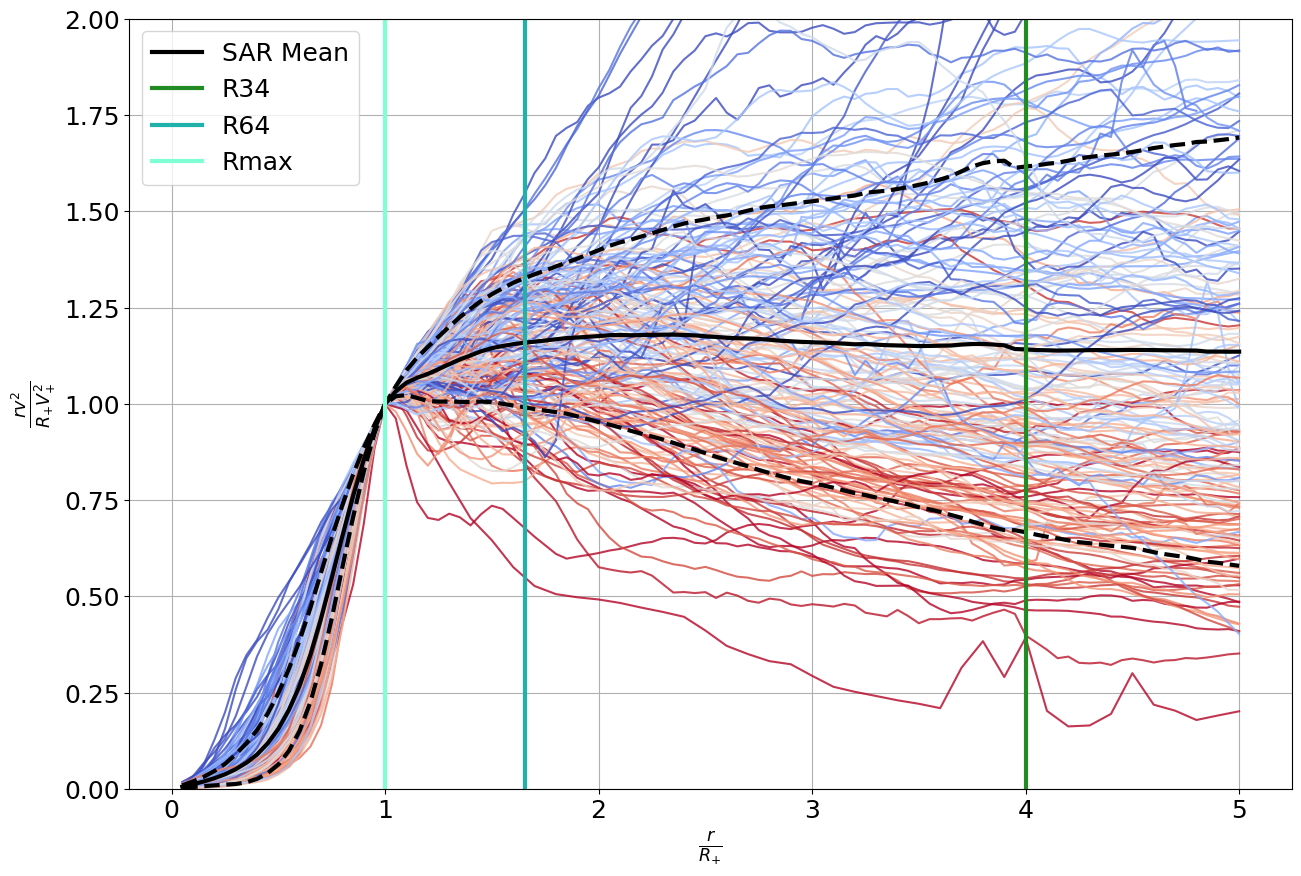

In [13]:
dss2['B_color'] = (dss2.B - 1.1) / (2.5 - 1.1)
cmap           = cm.get_cmap('coolwarm')

rv2m = dss2.mean(dim='i').rv2
rv2s = dss2.std(dim='i').rv2

for i in tqdm(np.arange(len(dss2.i))):
    dss2.isel(i=i).rv2.plot(color=cmap(dss2.isel(i=i).B_color), alpha=0.8)

rv2m.plot(c='k', linewidth=3, label='SAR Mean')
plt.plot(dss2.r_star, rv2m + rv2s, c='k', linestyle='dashed', linewidth=3)
plt.plot(dss2.r_star, rv2m - rv2s, c='k', linestyle='dashed', linewidth=3)


# plt.axvline(1, c='k', linewidth=3, label='R+')
plt.axvline((DSs.R17_1D.mean(skipna=True)) / DSs.Rmax_1D.mean(skipna=True),  c='forestgreen', label='R34', linewidth=3)
plt.axvline((DSs.R33_1D.mean(skipna=True)) / DSs.Rmax_1D.mean(skipna=True),  c='lightseagreen', label='R64', linewidth=3)
plt.axvline((DSs.Rmax_1D.mean(skipna=True)) / DSs.Rmax_1D.mean(skipna=True), c='aquamarine', label='Rmax', linewidth=3)
plt.grid();plt.legend()
plt.ylim(0, 2)
plt.ylabel(r'$\frac{rv^2}{R_{+} V_{+}^2}$')
plt.xlabel(r'$\frac{r}{R_{+}}$')
# plt.xlabel('r / R+')